# DiCE ML Comparison with Optimal Point Method 

We compare the DiCE Model-agnostic methods with the optimal point method in this notebook. 

1. First, we import DiCE ML model-agnostic methods 
2. Second, we import the packaged files needed to run the "Optimal Point" Methodology 
3. Third, we run the experiments and compare the results at the end using different models such as SVM and random forest classifier.
4. Finally, we compare the runtimes of DiCE and the Optimal Point methodology

# Step 1: Importing DiCE ML and helper functions 

Below we import DiCE ML and their relevant helper functions. We import the sci-kit learn library and some of their necessary methods to make sure that we can run the experiments. 

In [13]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
import json 
import datetime  

import warnings
import random
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Step 2: Import the necessary functionality to make Optimal Point methodology work 

We import many of the methods needed for the ```optimal_point()``` function to work as intended below. We import additional methods from ```binary_search_optimal_point().```

In [3]:
from files.common_functions import euclidean_distance, closest_border_point, closest_point, move_from_A_to_B_with_x1_displacement
from files.common_functions import get_multi_dim_border_points, det_constraints, real_world_constraints, constraint_bounds
from files.common_functions import balance_dataset, check_class_balance, convert_columns
from files.binary_search_optimal_point import find_decision_boundary, alpha_binary_search

In [4]:
df=pd.read_csv('../toy_dataset.csv')
# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True, random_state=1)

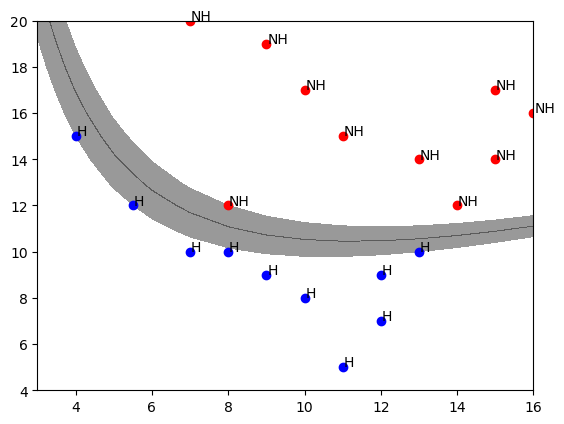

In [15]:
def visualize_dataset():
    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values
    # svm_classifier = svm.SVC(kernel='linear', C=10)
    #svm_classifier = svm.SVC(kernel='poly', C=10)
    svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
    # svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
    svm_classifier.fit(X_train, y_train)
    color_ls = []
    for k in y_train:
        if k == 1:
            color_ls.append('b')
        else:
            color_ls.append('r')
    color_ls
    label = []
    for k in y_train:
        if k == 1:
            label.append('H')
        else:
            label.append('NH')
    label
    def plot_decision_boundary(clf, X, y):
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max),np.arange(x2_min, x2_max))
        Z = clf.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        m = np.nonzero(Z < -19)
        Q = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, colors='k', levels=[-1, 0, 1], alpha=0.4,linestyles=['--', '-', '--'])
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        
    plot_decision_boundary(svm_classifier, X_train, y_train)

    for k, (i,j) in enumerate(X_train):
        plt.scatter(i, j, c = color_ls[k])
        plt.text(i+0.02, j+0.02, label[k])

visualize_dataset()

In [10]:
def optimal_point(dataset, model, desired_class, original_class, chosen_row=-1, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[], plot=False): 
    """
    Finds the closest point to the decision boundary from an undesired point,
    optionally constrained by real-world conditions.
    This essentially finds the counterfactual explanation for a given point by minimizing the distance to the given boundary.
    This method is important because it addresses a key problem with the original optimal_point() function where we generated an R^n dimensional grid that we would then have to iterate over. 
    The problem with iterating over such a grid is eventually that we will hit a memory error for high-dimensional features such as 20, 30 or 40 features. This will cause the function to crash. 
    Additionally, due to the exponential increase of the number of features to search, the grid will become infeasible to search (curse of dimensionality). 

    Parameters
    ----------
    dataset : pd.DataFrame
        Full dataset containing features and a final column with class labels.
    
    model : sklearn-like classifier
        A binary classification model with a `.fit()` and `.predict()` method.
    
    desired_class : int or label
        The target class we want the corrected point to belong to.
    
    original_class : int or label
        The actual class label of the undesired point.
    
    chosen_row :  int 
        The selected row of the dataset to find the counterfactual explanation for
    
    threshold : int, optional
        Max number of decision boundary points to sample. Default is 10000.
    
    point_epsilon : float, optional
        Precision used to estimate decision boundary points. Default is 0.1.
    
    epsilon : float, optional
        Step size used when displacing a point toward the decision boundary. Default is 0.01.
    
    constraints : list, optional
        A list of real-world constraints on the features (e.g., ranges, logic constraints). Default is [].
    
    deltas : list, optional
        Tolerances or maximum displacements for each feature. Default is [].

    Returns
    -------
    np.ndarray
        A corrected point that satisfies the class change and real-world constraints.

    Raises
    ------
    Exception
        If the number of constraints exceeds the number of features.

    Notes
    -----
    - This function trains the model on the provided dataset, generates boundary points using
      `find_decision_boundary`, applies constraints, and finds the closest optimal point.
    - Assumes binary classification and relies on external functions like `real_world_constraints`,
      `closest_point`, `move_from_A_to_B_with_x1_displacement`, etc., which must be defined elsewhere.
    - Includes plotting for visualization (e.g., boundary contours, points), which requires matplotlib.
    - The function blends boundary approximation with counterfactual generation, useful for explainable AI.
    - Print statements are for progress tracking; plotting is partially commented out but can be enabled.
    - Usage: Call with a dataset and model to generate counterfactuals, e.g., for model interpretation or optimization.

    Examples
    --------
    >>> import pandas as pd
    >>> from sklearn.linear_model import LogisticRegression
    >>> dataset = pd.DataFrame({'feat1': [0, 1, 2], 'feat2': [0, 1, 0], 'label': [0, 1, 0]})
    >>> model = LogisticRegression()
    >>> undesired_coords = [2, 0]  # Example point from class 0
    >>> optimal = optimal_point(dataset, model, desired_class=1, original_class=0, undesired_coords=undesired_coords)
    >>> print(optimal)  # e.g., array([[1.5, 0.5]])
    """

    # Convert categorical columns if needed (before balancing)
    inv_col_map = convert_columns(dataset)

    # Extract features and labels before balancing
    X_orig = dataset.iloc[:, :-1]
    
    # Save the original row's feature values
    undesired_coords = X_orig.iloc[chosen_row, :].copy()

    # Balance the dataset
    dataset = balance_dataset(df=dataset, target=dataset.columns[-1])
    
    if not check_class_balance(dataset, target=dataset.columns[-1]):
        raise RuntimeError("Failed to balance classes for binary classification")
    
    sampled_dataset = dataset.sample(n=min(dataset.shape[0], 10000))

    # Extract new training features/labels after balancing
    X_train = sampled_dataset.iloc[:, :-1]
    y_train = sampled_dataset.iloc[:, -1]
    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    # -------------------------------
    # STEP 2: Find decision boundary
    # -------------------------------
    print("boundary points started generation...")

    # This step uses binary interpolation to get points close to the decision boundary
    boundary_points = find_decision_boundary(model, X_train, y_train,
                                             threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)

    # -------------------------------
    # STEP 3: Apply real-world constraints (optional)
    # -------------------------------
    # Reduce boundary points based on external rules (e.g., cost limits, physics constraints)
    contours = real_world_constraints(points=boundary_points,
                                      undesired_coords=undesired_coords,
                                      constraints=constraints)
    contours = np.unique(contours.to_numpy(), axis=0)  # Remove duplicates from constrained points
    undesired_datapt = np.reshape(undesired_coords, (1, -1))  # Reshape undesired point to 2D array

    # -------------------------------
    # STEP 4: Find closest point on constrained boundary
    # -------------------------------
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")  # Note: Duplicate print, possibly a typo
    if plot:
        plt.plot(contours[:,0], contours[:,1], lw=0.5, color='red')  # Commented: Plot contours for visualization

    # -------------------------------
    # STEP 5: Post-process based on class flip requirement
    # -------------------------------

    # If we want to *flip* the class of the point...
    if desired_class != original_class: 
         # Move in the direction of the boundary, slightly overshooting
        D = optimal_datapt - undesired_datapt  # Compute direction vector
        deltas = D * (1+epsilon)  # Scale by (1 + epsilon) to overshoot
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else:
        # If we want to *stay within* the same class (more constrained)
        closest_boundedpt = None
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], deltas=deltas)  # Determine constraints

        if len_constr > X_train.shape[1]:
            raise Exception("There cannot be more constraints than features")

        elif len_constr == X_train.shape[1]:
            # All n dimensions are constrained, so generate an exact grid of boundary candidates
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0],
                                                              extents=deltas,
                                                              step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)  # Convert to NumPy array
            x_values, y_values = np_bounded_contour[:, 0], np_bounded_contour[:, 1]  # Extract x/y for plotting
            #plt.scatter(x_values, y_values, marker='o')  # Plot bounded points
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)  # Find closest on border

        else:
            # Partially constrained - less than n dimensions are constrained
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, deltas)  # Apply partial bounds
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)  # Find closest
        
        D = closest_boundedpt - undesired_datapt  # Compute direction
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)  # Move point
    
    # Plot original and optimal points with connecting line
    if plot:
        plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')  # Plot undesired point
        plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')  # Label 'NH' (e.g., Non-Healthy)
        plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'g')  # Plot optimal point (changed to green for distinction)
        plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
        plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')  # Dashed line between points
    
    categorical_features = [col for col in inv_col_map.keys()]
    final_optimal_datapt = [] 

    for col in X_train.columns:
        if col in categorical_features: 
            idx = optimal_datapt[0,X_train.columns.get_loc(col)].astype(int)
            final_optimal_datapt.append(inv_col_map[col][idx])
        else: 
            final_optimal_datapt.append(optimal_datapt[0,X_train.columns.get_loc(col)])

    query_instance = undesired_coords
    return dataset, model, query_instance, final_optimal_datapt, euclidean_distance(undesired_datapt, optimal_datapt)

In [11]:
def run_dice_cfs(df, model, query_instance, method, continuous_features, target, chosen_row, plot=False, total_CFs=1):
    start = datetime.datetime.now()
    x_train = df.iloc[:, :-1]
    backend = 'sklearn'

    d = dice_ml.Data(dataframe=df, continuous_features=continuous_features, outcome_name=target)
    m = dice_ml.Model(model=model, backend=backend)
    exp_dice = dice_ml.Dice(d, m, method=method)
    
    sampled_dataset = df.sample(n=min(df.shape[0], 10000))

    # Extract new training features/labels after balancing
    X_train = sampled_dataset.iloc[:, :-1]
    y_train = sampled_dataset.iloc[:, -1]
    # Train the model
    print("Fitting model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    print("QUERY INSTANCE")
    query_instance = x_train.iloc[[chosen_row]] 

    dice_cfs = exp_dice.generate_counterfactuals(pd.DataFrame(data=query_instance, columns=x_train.columns), total_CFs=total_CFs, desired_class="opposite")
    cfs_list = json.loads(dice_cfs.to_json())['cfs_list']

    query_instance = np.array(query_instance)
    dist_cfs = []
    for point in cfs_list[0]: 
        point_vec = [float(point[i]) for i in range(len(point[:-1]))]
        dist_cfs.append(euclidean_distance(np.array(point_vec), query_instance))

    # average_distance_cfs /= len(cfs_list[0])
    # print("AVERAGE EUCLIDEAN DISTANCE AMONG 100 CFS", average_distance_cfs)

    if plot:
        for point in cfs_list[0][:5]: 
            print(point)
            x,y = point[0], point[1] 
            print("EUCLIDEAN DISTANCE:", euclidean_distance(np.array((x,y)), query_instance))
            print(query_instance)
            plt.scatter(x,y, c = 'yellow')  # Plot optimal point (changed to green for distinction)
            plt.text(x+0.002, y+0.002, 'H')  # Label 'H' (e.g., Healthy; adjusted from duplicate 'NH')
            plt.plot([x,query_instance[0][0]], [y, query_instance[0][1]], linestyle='--')  # Dashed line between points
    end = datetime.datetime.now()
    diff = end - start
    print(f"Elapsed time: {diff}")

    return dist_cfs, diff.total_seconds()

# Step 3: Toy Dataset Experiments

We run a few experiments using the toy dataset, and we compare the results visually using both the optimal point method and the dice model-agnostic methods. 

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset[target] = balanced_dataset[target].astype('int32')


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07321905 1.07023609]]
[[-0.33339643 -4.53316927]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 82.86it/s]

[4.0, 15.0, 1.0]
EUCLIDEAN DISTANCE: 7.0
[[11. 15.]]
Elapsed time: 0:00:00.019150


([7.0], 0.01915)

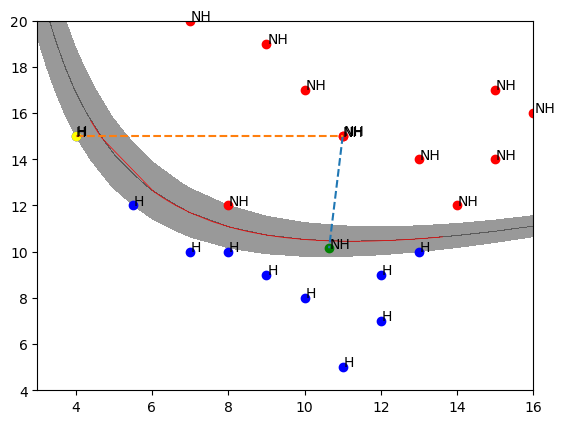

In [ ]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[4:5,:]
chosen_row=4
visualize_dataset()
df, model, query_instance, opt_point, _ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset[target] = balanced_dataset[target].astype('int32')


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07438206 1.07023586]]
[[-0.24517727 -4.53764772]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 26.38it/s]

[12.2, 11.6, -1.0]
EUCLIDEAN DISTANCE: 3.605551275463989
[[11. 15.]]
Elapsed time: 0:00:00.047576


([3.605551275463989], 0.047576)

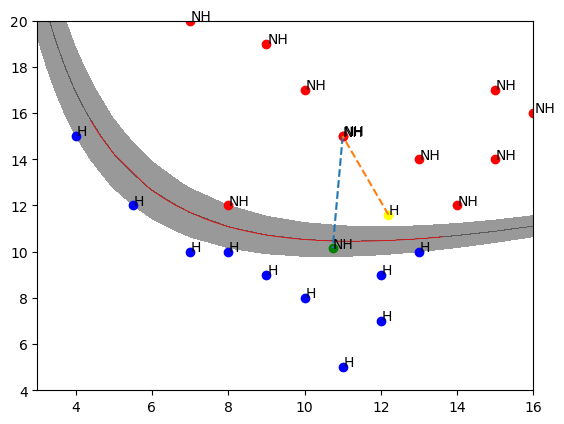

In [22]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[4:5,:]
chosen_row=4
visualize_dataset()
df, model, query_instance, opt_point,_ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset[target] = balanced_dataset[target].astype('int32')


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.         1.07023542]]
[[ 0.         -4.54614162]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 62.50it/s]

[4.0, 15.0, 1.0]
EUCLIDEAN DISTANCE: 7.0
[[11. 15.]]
Elapsed time: 0:00:00.031098


([7.0], 0.031098)

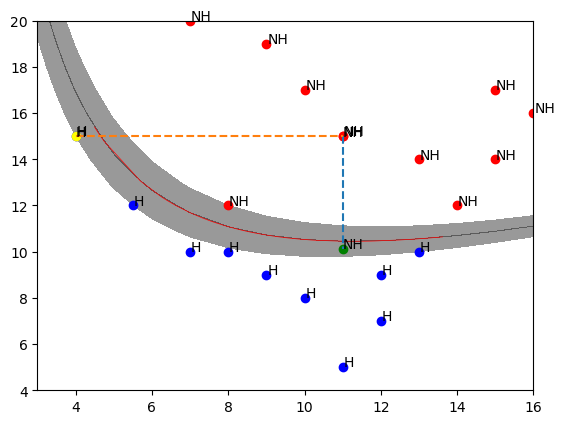

In [23]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[4:5,:]
chosen_row=4
visualize_dataset()
df, model, query_instance, opt_point,_ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset[target] = balanced_dataset[target].astype('int32')


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06786094 1.07031697]]
[[ 0.49921989 -3.37675524]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 83.33it/s]

[13.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 4.0
[[13. 14.]]
Elapsed time: 0:00:00.020000


([4.0], 0.02)

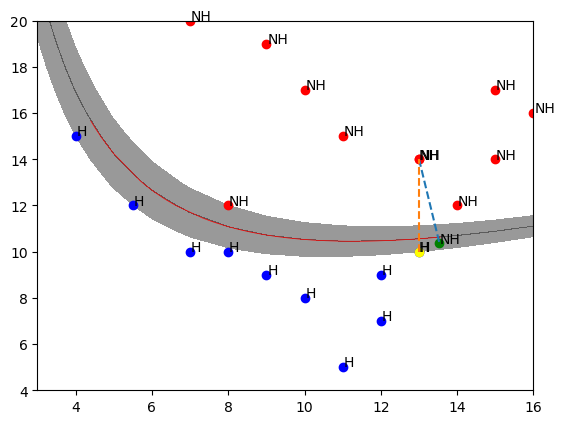

In [25]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[5:6,:]
chosen_row=5
visualize_dataset()
df, model, query_instance, opt_point,_= optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset[target] = balanced_dataset[target].astype('int32')


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06809249 1.07031778]]
[[ 0.55994081 -3.36813021]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 29.35it/s]

[6.9, 7.1, 1.0]
EUCLIDEAN DISTANCE: 9.2097774131626
[[13. 14.]]
Elapsed time: 0:00:00.041076


([9.2097774131626], 0.041076)

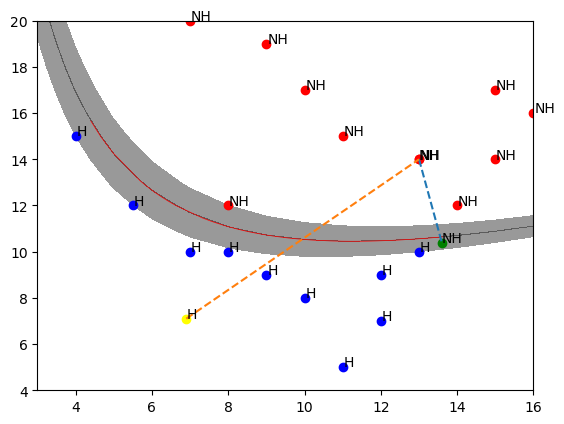

In [26]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[5:6,:]
chosen_row=5
visualize_dataset()
df, model, query_instance, opt_point, _ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=True)

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset[target] = balanced_dataset[target].astype('int32')


Class counts:
 y
-1    10
 1    10
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...
boundary points finished.
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.06786094 1.07031697]]
[[ 0.49921989 -3.37675524]]
Fitting model...
Model training complete.
QUERY INSTANCE


100%|██████████| 1/1 [00:00<00:00, 60.08it/s]

[13.0, 10.0, 1.0]
EUCLIDEAN DISTANCE: 4.0
[[13. 14.]]
Elapsed time: 0:00:00.025644


([4.0], 0.025644)

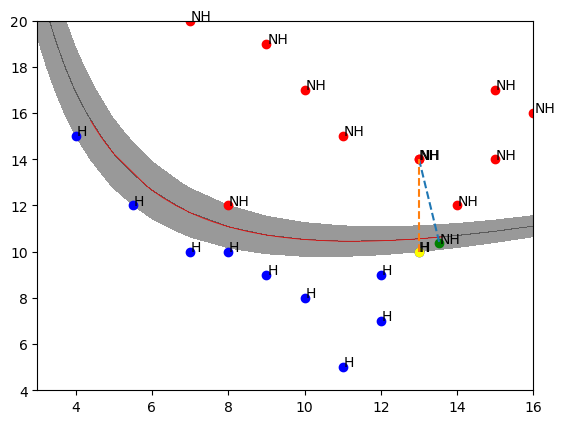

In [ ]:
x_train = df.iloc[:,:-1]
continuous_features=['x1', 'x2']
target='y'
query_instance=x_train.iloc[5:6,:]
chosen_row=5
visualize_dataset()
df, model, query_instance, opt_point, _ = optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=True)
run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=True)

In [ ]:
inv_map = { 
    1: -1, 
    -1: 1
}
x_train = df.iloc[:,:-1]
y_train  = df.iloc[:,-1]
continuous_features=['x1', 'x2']
target='y'
dice_dists, optimal_dists = [], [] 
for i in range(df.shape[0]):
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(df, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=1000, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=False)
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=False)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
inv_map = { 
    1: -1, 
    -1: 1
}
x_train = df.iloc[:,:-1]
y_train  = df.iloc[:,-1]
continuous_features=['x1', 'x2']
target='y'
dice_dists, optimal_dists = [], [] 
for i in range(df.shape[0]):
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(df, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=1000, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=False)
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=False)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
inv_map = { 
    1: -1, 
    -1: 1
}
x_train = df.iloc[:,:-1]
y_train  = df.iloc[:,-1]
continuous_features=['x1', 'x2']
target='y'
dice_dists, optimal_dists = [], [] 
for i in range(df.shape[0]):
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(df, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=100, chosen_row=chosen_row, point_epsilon=1e-6, epsilon=0.07, constraints=[], plot=False)
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row, plot=False)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

# Step 3: Adult Income Dataset Experiments

We run a few experiments using the adult income dataset comparing DiCE model-agnostic methodologies and the Optimal Point method.

We follow the following steps: 

1. Import the dataset using the helpers function from DiCE 
2. Initialize the classifier which is a Random Forest Classifier in this case
3. Iterate for 50 or 100 randomly selected points using the Optimal point method 
4. After each iteration of generation with the optimal point method, we apply the run_dice_cfs method that enables us to generate counterfactuals using DiCE's specific model-agnostic approach

In [5]:
dataset = helpers.load_adult_income_dataset()

c:\Users\Compuworld\anaconda3\Lib\site-packages\dice_ml\utils\helpers.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data = adult_data.replace({'income': {'<=50K': 0, '>50K': 1}})


In [6]:
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [8]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = RandomForestClassifier()

In [12]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
query_instance=x_train.iloc[4:5,:]
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

c:\Users\Compuworld\drexel_research_2024_2025\files\common_functions.py:422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_dataset = pd.concat([balanced_dataset, upsampled_class], ignore_index=True)


Class counts:
 income
0    19820
1    19820
Name: count, dtype: int64
Fitting model...
Model training complete.
boundary points started generation...


KeyboardInterrupt: 

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
query_instance=x_train.iloc[4:5,:]
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
query_instance=x_train.iloc[4:5,:]
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
sub_dataset = dataset[dataset['income'] == 0]
random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 50)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train.shape

In [ ]:
x_train = dataset.iloc[:,:-1]
y_train = dataset.iloc[:,-1]
continuous_features=["age", "hours_per_week"]
target='income'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
random_integers = random.sample(range(1, 26047), 50)

for i in random_integers:
    chosen_row=i
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    label = y_train.iloc[chosen_row:chosen_row+1]
    df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

# Step 3: Heart Disease Dataset Experiments

We run a few experiments using the heart disease dataset comparing DiCE model-agnostic methodologies and the Optimal Point method.

We follow the following steps: 

1. Import the dataset using the helpers function from DiCE 
2. Initialize the classifier which is a Random Forest Classifier in this case
3. Iterate for 50 or 100 randomly selected points using the Optimal point method 
4. After each iteration of generation with the optimal point method, we apply the run_dice_cfs method that enables us to generate counterfactuals using DiCE's specific model-agnostic approach

In [ ]:
heart_disease = pd.read_csv(
'../heart.csv'
)

In [ ]:
heart_disease

In [ ]:
x_train = heart_disease.iloc[:,:-1]
y_train = heart_disease.iloc[:,-1]
continuous_features=["age", "trestbps", "thalach", "oldpeak", "chol"]
target='target'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
dice_probs, optimal_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]

random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 100)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    df, model, query_instance, opt_point, dist = optimal_point(heart_disease, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='kdtree', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train = heart_disease.iloc[:,:-1]
y_train = heart_disease.iloc[:,-1]
continuous_features=["age", "trestbps", "thalach", "oldpeak", "chol"]
target='target'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
dice_probs, optimal_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]

random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 100)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    df, model, query_instance, opt_point, dist = optimal_point(heart_disease, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=10000, chosen_row=chosen_row, point_epsilon=1e-4, epsilon=0.001, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='random', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

In [ ]:
x_train = heart_disease.iloc[:,:-1]
y_train = heart_disease.iloc[:,-1]
continuous_features=["age", "trestbps", "thalach", "oldpeak", "chol"]
target='target'
inv_map = { 
    0: 1, 
    1: 0
}
dice_dists, optimal_dists = [], [] 
dice_probs, optimal_probs = [], [] 
sub_dataset = heart_disease[heart_disease['target'] == 1]

random_integers = random.sample(range(0, sub_dataset.shape[0]-1), 100)
for i in random_integers:
    real_idx = sub_dataset.index[i]
    chosen_row=real_idx
    query_instance=x_train.iloc[chosen_row:chosen_row+1,:]
    df, model, query_instance, opt_point, dist = optimal_point(heart_disease, svm_classifier, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
    optimal_dists.append(dist)
    dist_cfs = run_dice_cfs(df=df, model=model,query_instance=query_instance,method='genetic', continuous_features=continuous_features, target=target, chosen_row=chosen_row)
    dice_dists.extend(dist_cfs)

In [ ]:
print(np.mean(optimal_dists), np.mean(dice_dists))

# Step 4: Runtime Tests 

The function ```runtime_tests()``` are used for comparing DiCE's model-agnostic approaches and Optimal Point for time complexity. We use a logistic regression classifier for examining runtime.

In [ ]:
def runtime_tests(number_of_features, method, total_random=100):
    X, y = make_classification(n_samples=5000, n_features=number_of_features, n_informative=number_of_features,
                            n_redundant=0, n_classes=2, random_state=42)
    y = np.reshape(y, (-1, 1))
    columns = ["x"+str(i) for i in range(1, X.shape[1]+1)] 
    columns.append('y')
    dataset = pd.DataFrame(data=np.hstack((X,y)), columns=columns)
    continuous_features=["x"+str(i) for i in range(1, X.shape[1]+1)]
    target='y'
    inv_map = { 
        0: 1, 
        1: 0
    }
    dice_dists, optimal_dists = [], []
    dice_runtime = [] 
    sub_dataset = dataset[dataset[target] == 0]
    random_integers = random.sample(range(1, sub_dataset.shape[0]), total_random)
    clf = LogisticRegression()

    for i in random_integers:
        real_idx = sub_dataset.index[i]
        chosen_row=real_idx
        query_instance=X[chosen_row:chosen_row+1,:]
        label = y[chosen_row:chosen_row+1]
        df, model, query_instance, opt_point, dist = optimal_point(dataset, clf, desired_class=inv_map[label.item()], original_class=label.item(), threshold=5000, chosen_row=chosen_row, point_epsilon=1e-3, epsilon=0.01, constraints=[])
        optimal_dists.append(dist)
        dist_cfs, total_seconds = run_dice_cfs(df=df, model=model,query_instance=query_instance,method=method, continuous_features=continuous_features, target=target, chosen_row=chosen_row)
        dice_dists.extend(dist_cfs)
        dice_runtime.append(total_seconds)

    print(np.mean(dice_runtime))

In [ ]:
runtime_tests(number_of_features=10, method='kdtree')

In [ ]:
runtime_tests(number_of_features=50, method='kdtree')

In [ ]:
runtime_tests(number_of_features=10, method='random')

In [ ]:
runtime_tests(number_of_features=50, method='random')

In [ ]:
runtime_tests(number_of_features=10, method='genetic')

In [ ]:
runtime_tests(number_of_features=50, method='genetic')